In [1]:
from tdc.single_pred import ADME
import numpy as np
import pandas as pd
from matminer.datasets.dataset_retrieval import load_dataset
from matminer.featurizers.conversions import StrToComposition
from matminer.utils.io import store_dataframe_as_json
from tqdm import tqdm
from noiseestimator import NoiseEstimator

In [2]:
df = load_dataset("expt_gap")
df = df.rename(columns={"formula": "composition"})
len(df) # of not de-duplicated entries

6354

In [3]:
# print(df[df["composition"] == "ZrW2"])  # should be 0.00
# print(df[df["composition"] == "ZrSe2"]) # should be 2.00

In [4]:
df = StrToComposition(target_col_id="composition_obj").featurize_dataframe(
    df, "composition"
)
df["composition"] = [c.reduced_formula for c in df["composition_obj"]]
df = df.drop(columns=["composition_obj"])

unique = df["composition"].unique()
print("Number of unique compositions:", len(unique))

StrToComposition:   0%|          | 0/6354 [00:00<?, ?it/s]

Number of unique compositions: 4921


In [5]:
new_df_dict = {"composition": [], "gap expt": []}
std_dv = 0
n = 0
import math 

for c in tqdm(unique):
    df_per_comp_gaps = df[df["composition"] == c]
    per_comp_gaps = df_per_comp_gaps["gap expt"].to_numpy()
    if len(per_comp_gaps) > 1:
    # get all pairs of gaps
        for i in range(len(per_comp_gaps)):
            for j in range(i + 1, len(per_comp_gaps)):
                std_dv += (per_comp_gaps[i] - per_comp_gaps[j])**2
                n += 1
std_dv = math.sqrt(std_dv / (2 * (n - 1)))
print(std_dv)

  0%|          | 0/4921 [00:00<?, ?it/s]

100%|██████████| 4921/4921 [00:02<00:00, 1798.41it/s]

0.14115281907509952


In [6]:
from matbench.bench import MatbenchBenchmark

In [7]:
mb = MatbenchBenchmark(autoload=False, subset=['matbench_expt_gap'])
for task in mb.tasks:
    task.load()
    df = task.df
dataset = df['gap expt']

2024-04-17 18:09:25 INFO     Initialized benchmark 'matbench_v0.1' with 1 tasks: 
['matbench_expt_gap']
2024-04-17 18:09:25 INFO     Loading dataset 'matbench_expt_gap'...
2024-04-17 18:09:25 INFO     Dataset 'matbench_expt_gap loaded.


In [8]:
range = dataset.max() - dataset.min()
print(range)

11.7


In [10]:
dataset.to_csv('../data/processed/matbench_gap.csv', index=False)

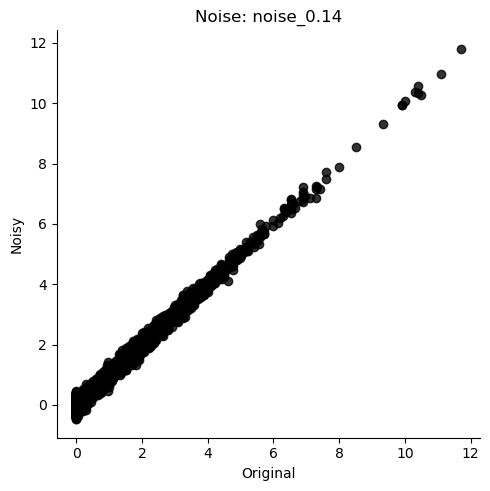

In [8]:
NE = NoiseEstimator(dataset, 0.14)
NE.plot()

<Axes: title={'center': 'mae for different noise levels'}, xlabel='Noise level', ylabel='mae'>

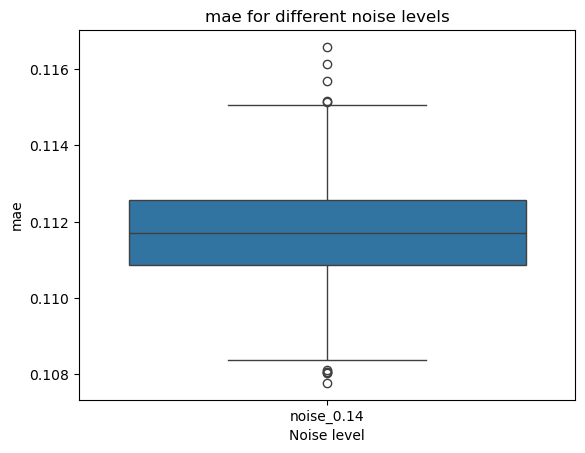

In [9]:
NE.plot_bootstrap(metric='mae')

In [10]:
NE.noise_bootstraps.groupby('noise').mean()

,mae,mse,rmse,r2,pearsonr
noise,,,,,
noise_0.14,0.111706,0.019606,0.140014,0.990609,0.995339


<Axes: title={'center': 'mae for different noise levels'}, xlabel='Noise level', ylabel='mae'>

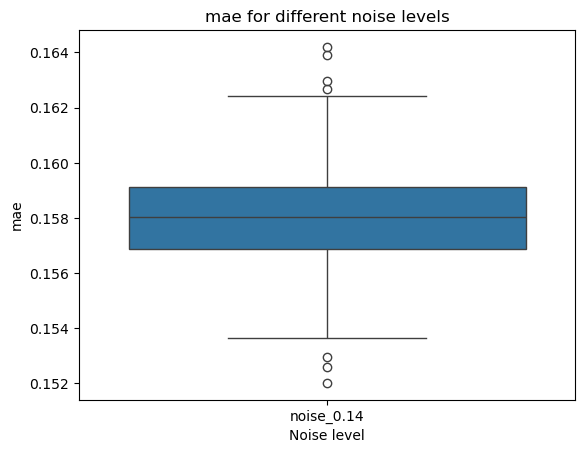

In [11]:
NE = NoiseEstimator(dataset, 0.14, 0.14)
NE.plot_bootstrap(metric='mae')

In [12]:
NE.noise_bootstraps.groupby('noise').mean()

,mae,mse,rmse,r2,pearsonr
noise,,,,,
noise_0.14,0.158027,0.03923,0.198055,0.981382,0.990695


In [13]:
NE.noise_bootstraps.mae.to_csv('../data/interim/matbench_expt_gap_MAE.csv')